In [2]:
import os
import sys
from PIL import Image
import numpy as np
from skimage.filters import threshold_multiotsu, threshold_local
import matplotlib.pyplot as plt

In [3]:
# Aktuelles Arbeitsverzeichnis als Projekt-Root
project_root = os.getcwd()
src_dir      = os.path.join(project_root, "src")

# src-Verzeichnis ins Python-Modulverzeichnis aufnehmen
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# Bild laden und in ein Grauwert-Array umwandeln
img_path = os.path.join(project_root, "Data", "N2DH-GOWT1", "img", "t01.tif")
pil_image = Image.open(img_path).convert("L")
img_array = np.array(pil_image)



In [4]:
# Otsu Global
from otsu_global import apply_global_otsu

otsu_global_result = apply_global_otsu(img_array)


In [5]:
# Otsu Local

block_size = 65
local_thresh = threshold_local(img_array, block_size=block_size, offset=0)
otsu_local_result = img_array > local_thresh  # dtype: bool

In [6]:
# Otsu Multi 

thresholds = threshold_multiotsu(img_array, classes=3)
multi_otsu_result = np.digitize(img_array, bins=thresholds)

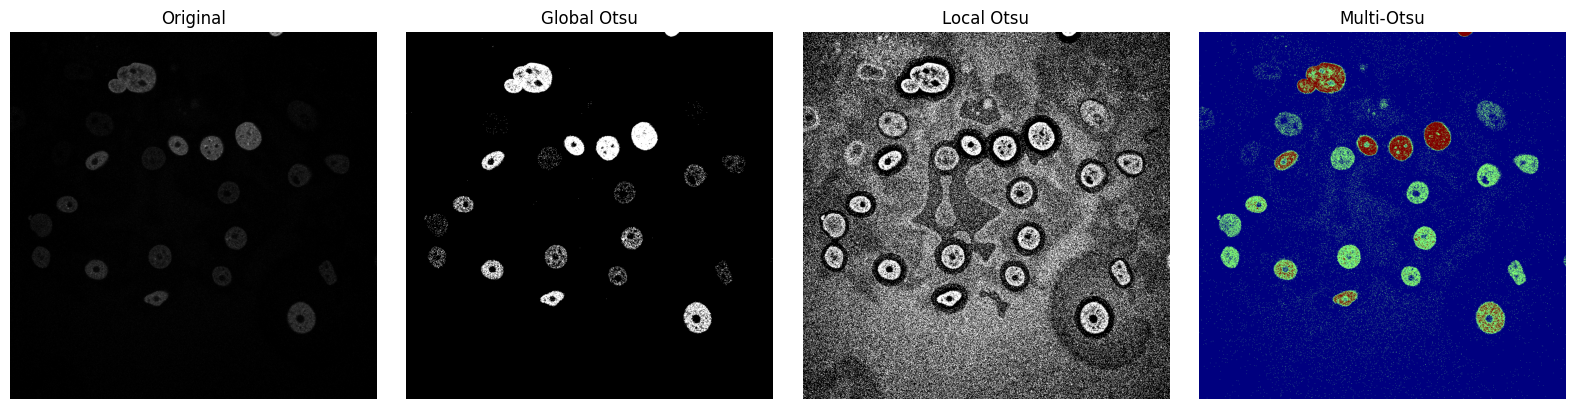

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(otsu_global_result, cmap='gray')
axes[1].set_title("Global Otsu")
axes[2].imshow(otsu_local_result, cmap='gray')
axes[2].set_title("Local Otsu")
axes[3].imshow(multi_otsu_result, cmap='jet')
axes[3].set_title("Multi-Otsu")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Dice Score (F1): Misst die Überlappung zwischen Vorhersage und Ground Truth. [0–1]


IoU (Jaccard Index): Intersection over Union. Etwas strenger als Dice. [0–1]

In [10]:
def dice_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum() + 1e-8)

def iou_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / (union + 1e-8)

In [11]:
# Ground Truth laden
gt_path = os.path.join(project_root, "Data", "N2DH-GOWT1", "gt", "man_seg01.tif")
gt_mask = np.array(Image.open(gt_path).convert("L")) > 0  # binär

In [12]:
methods = {
    "Global Otsu": otsu_global_result,
    "Local Otsu": otsu_local_result,
    "Multi-Otsu": multi_otsu_result == 2  # Annahme: Klasse 2 = Zellen
}

for name, result in methods.items():
    dice = dice_score(gt_mask, result)
    iou = iou_score(gt_mask, result)
    print(f"{name}: Dice = {dice:.3f}, IoU = {iou:.3f}")


Global Otsu: Dice = 0.571, IoU = 0.399
Local Otsu: Dice = 0.214, IoU = 0.120
Multi-Otsu: Dice = 0.399, IoU = 0.249


In [14]:
def best_matching_multiotsu_class(multi_result: np.ndarray, gt_mask: np.ndarray) -> np.ndarray:
    best_score = -1
    best_mask = None
    for i in np.unique(multi_result):
        mask = multi_result == i
        dice = dice_score(gt_mask, mask)
        if dice > best_score:
            best_score = dice
            best_mask = mask
    return best_mask

In [15]:
multi_otsu_result = np.digitize(img_array, bins=threshold_multiotsu(img_array, classes=3))
multi_otsu_best = best_matching_multiotsu_class(multi_otsu_result, gt_mask)
